# Evaluation of the `HaGraD`-Optimizer with Mnist-Dataset
---

## Imports and Data-Preparation

In [69]:
## Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## General
import numpy as np
import matplotlib.pyplot as plt

## Hagrad custom optimizer
from hagrad import Hagrad
from hagrad import KineticEnergyGradients

In [70]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape  == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape  == (10000,)

In [71]:
## Class number sanity check
num_classes = 10
assert set(np.unique(y_train)) == set(np.arange(num_classes))

## Normalizing and expanding dimensions for ConvLayers
def normalize_img_data(X: np.ndarray) -> np.ndarray:
    X = X.astype(np.float32) / 255.
    X = np.expand_dims(X, -1)
    return X

X_train = normalize_img_data(X_train)
X_test  = normalize_img_data(X_test)

## convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

---

## Defining the Model

In [72]:
## Using a standard Dense-Model here - sufficient for mnist.
def fully_connected_NN(
    input_shape: tuple,
    num_classes: int,
    optimizer: keras.optimizers.Optimizer,
    print_summary: bool=False) -> keras.Model:

    ## Defining the Model with Sequential API
    model = keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128),
        layers.Dense(128),
        layers.Dense(128),
        layers.Dense(num_classes, activation="softmax")
    ])
    
    ## Compiling the Model using the given Optimizer
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(), 
        optimizer=optimizer, 
        metrics=["accuracy"])

    ## Optional: Print Model summary
    if print_summary: print(model.summary())

    return model


---

## Train the Network using different Optimizers

In [73]:
## Settings
batch_size  = 128
epochs      = 50
input_shape = X_train.shape[1:]

In [74]:
## Wrappers
def model_optimizer(optimizer):
    model = fully_connected_NN(
        input_shape=input_shape, 
        num_classes=num_classes, 
        optimizer=optimizer, 
        print_summary=False)
    return model

def model_fit(model, verbose=2):
    fit = model.fit(
        X_train, y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(X_train, y_train), 
        verbose=verbose)
    return fit

#### Adam

In [75]:
keras.backend.clear_session()
model_adam = model_optimizer(keras.optimizers.Adam())
fit_adam = model_fit(model_adam)

Epoch 1/50
469/469 - 3s - loss: 0.3823 - accuracy: 0.8891 - val_loss: 0.2938 - val_accuracy: 0.9162
Epoch 2/50
469/469 - 2s - loss: 0.3070 - accuracy: 0.9124 - val_loss: 0.3004 - val_accuracy: 0.9157
Epoch 3/50
469/469 - 2s - loss: 0.2994 - accuracy: 0.9152 - val_loss: 0.2675 - val_accuracy: 0.9247
Epoch 4/50
469/469 - 2s - loss: 0.2906 - accuracy: 0.9180 - val_loss: 0.2761 - val_accuracy: 0.9215
Epoch 5/50
469/469 - 2s - loss: 0.2838 - accuracy: 0.9202 - val_loss: 0.2635 - val_accuracy: 0.9255
Epoch 6/50
469/469 - 2s - loss: 0.2854 - accuracy: 0.9197 - val_loss: 0.2574 - val_accuracy: 0.9279
Epoch 7/50
469/469 - 2s - loss: 0.2801 - accuracy: 0.9209 - val_loss: 0.2626 - val_accuracy: 0.9261
Epoch 8/50
469/469 - 2s - loss: 0.2774 - accuracy: 0.9215 - val_loss: 0.2667 - val_accuracy: 0.9238
Epoch 9/50
469/469 - 2s - loss: 0.2770 - accuracy: 0.9218 - val_loss: 0.2557 - val_accuracy: 0.9266
Epoch 10/50
469/469 - 2s - loss: 0.2734 - accuracy: 0.9228 - val_loss: 0.2555 - val_accuracy: 0.9274

### SGD

In [76]:
keras.backend.clear_session()
model_sgd = model_optimizer(keras.optimizers.SGD())
fit_sgd = model_fit(model_sgd)

Epoch 1/50
469/469 - 3s - loss: 0.7706 - accuracy: 0.7883 - val_loss: 0.4451 - val_accuracy: 0.8759
Epoch 2/50
469/469 - 2s - loss: 0.3999 - accuracy: 0.8870 - val_loss: 0.3675 - val_accuracy: 0.8960
Epoch 3/50
469/469 - 2s - loss: 0.3533 - accuracy: 0.8990 - val_loss: 0.3392 - val_accuracy: 0.9036
Epoch 4/50
469/469 - 2s - loss: 0.3322 - accuracy: 0.9052 - val_loss: 0.3217 - val_accuracy: 0.9086
Epoch 5/50
469/469 - 2s - loss: 0.3191 - accuracy: 0.9094 - val_loss: 0.3113 - val_accuracy: 0.9115
Epoch 6/50
469/469 - 2s - loss: 0.3103 - accuracy: 0.9116 - val_loss: 0.3046 - val_accuracy: 0.9135
Epoch 7/50
469/469 - 2s - loss: 0.3034 - accuracy: 0.9144 - val_loss: 0.2996 - val_accuracy: 0.9153
Epoch 8/50
469/469 - 2s - loss: 0.2983 - accuracy: 0.9156 - val_loss: 0.2946 - val_accuracy: 0.9170
Epoch 9/50
469/469 - 2s - loss: 0.2941 - accuracy: 0.9171 - val_loss: 0.2896 - val_accuracy: 0.9191
Epoch 10/50
469/469 - 2s - loss: 0.2904 - accuracy: 0.9183 - val_loss: 0.2855 - val_accuracy: 0.9198

### HaGraD

In [77]:
keras.backend.clear_session()
hagrad_optimizer = Hagrad()
print(hagrad_optimizer.get_config())
model_hagrad = model_optimizer(hagrad_optimizer)
fit_hagrad = model_fit(model_hagrad)

{'name': 'hagrad', 'epsilon': 1.0, 'gamma': 10.0, 'delta': 0.09090909090909091, 'kinetic_energy_gradient': 'Relativistic kinetic energy sqrt( ||p||^2 + 1 )-1 with gradient p/sqrt( ||p||^2 + 1 )'}
Epoch 1/50
469/469 - 3s - loss: 0.4206 - accuracy: 0.8770 - val_loss: 0.3112 - val_accuracy: 0.9104
Epoch 2/50
469/469 - 3s - loss: 0.3166 - accuracy: 0.9099 - val_loss: 0.2908 - val_accuracy: 0.9182
Epoch 3/50
469/469 - 3s - loss: 0.3026 - accuracy: 0.9132 - val_loss: 0.3020 - val_accuracy: 0.9128
Epoch 4/50
469/469 - 3s - loss: 0.2957 - accuracy: 0.9154 - val_loss: 0.2948 - val_accuracy: 0.9138
Epoch 5/50
469/469 - 2s - loss: 0.2895 - accuracy: 0.9183 - val_loss: 0.2716 - val_accuracy: 0.9241
Epoch 6/50
469/469 - 2s - loss: 0.2856 - accuracy: 0.9191 - val_loss: 0.2765 - val_accuracy: 0.9226
Epoch 7/50
469/469 - 3s - loss: 0.2832 - accuracy: 0.9205 - val_loss: 0.2713 - val_accuracy: 0.9237
Epoch 8/50
469/469 - 3s - loss: 0.2792 - accuracy: 0.9215 - val_loss: 0.2720 - val_accuracy: 0.9232
Epoc

---

## Visualizing

Keras is evaluating the validation error at the end of each epoch. Therefore teh validation errors get shifted for the visualization:

In [78]:
epochs_arr = np.arange(epochs)
epochs_arr_val = epochs_arr + 0.5

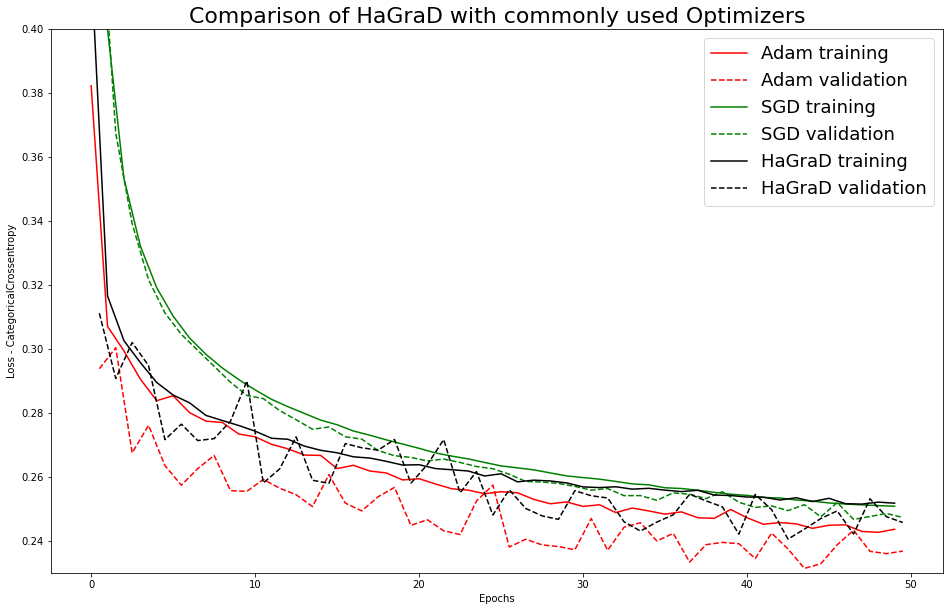

In [79]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Comparison of HaGraD with commonly used Optimizers", fontsize=22)
ax.plot(epochs_arr,     fit_adam.history['loss'],       "r-",  label="Adam training") 
ax.plot(epochs_arr_val, fit_adam.history['val_loss'],   "r--", label="Adam validation") 
ax.plot(epochs_arr,     fit_sgd.history['loss'],        "g-",  label="SGD training") 
ax.plot(epochs_arr_val, fit_sgd.history['val_loss'],    "g--", label="SGD validation") 
ax.plot(epochs_arr,     fit_hagrad.history['loss'],     "k-",  label="HaGraD training") 
ax.plot(epochs_arr_val, fit_hagrad.history['val_loss'], "k--", label="HaGraD validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss - CategoricalCrossentropy")
ax.set_ylim(bottom=0.23, top=0.4)
leg = ax.legend(frameon=True, fontsize=18)
plt.show()
plt.close()

---